In [1]:
#import all packages for this notebook
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv('data/CreditcardDefaults.csv')
df.rename(columns={'default payment next month':'default'}, inplace=True)

#set index to the "ID" value and remove the ID column
df.index = df.ID
del df['ID']

#Create Lists for Analysis
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6','default']

#Convert datatypes
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#Log transform continuous variables; as they each have a mostly 
##exponential distribution
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)

# One-hot encoding of "EDUCATION" and "MARRIAGE".
tmp_df_1 = pd.get_dummies(df.EDUCATION,prefix='EDUCATION')
tmp_df_2 = pd.get_dummies(df.MARRIAGE,prefix='MARRIAGE')
df = pd.concat((df,tmp_df_1,tmp_df_2),axis=1)

In [5]:
# This cell computes a bunch of new variables.  Graphs showing the relationship to default are in the next cell.

# New variable to get the max delinquency for each customer
df['MaxDelinq'] = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].max(axis=1)  # See graphs in the next cell for all output.

#######################################################################################
# this next long chunk of code calculates a series of variables:
# 1) Number of times a customer has been one month late, 2 months late, 3 months late and so on...
# 2) Using these also calculate:
#     a) How many times a customer has been 2 or more months late 
#     b) how many times they have been 3 or more months late, and
#     c) Whether or not they have been 2 or more months late.



# Setting up a variable to count the number of times a customer has been one month late.
# First set up a variable for each month's payment.  Will be 0 unless payment was one month late.
df['Del1_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del1_2']=0 # Month 2
df['Del1_3']=0 # etc ...
df['Del1_4']=0
df['Del1_5']=0
df['Del1_6']=0

# set the values to 1 if payment was one month late.
df.loc[df['PAY_0'] == 1, 'Del1_0'] = 1
df.loc[df['PAY_2'] == 1, 'Del1_2'] = 1
df.loc[df['PAY_3'] == 1, 'Del1_3'] = 1
df.loc[df['PAY_4'] == 1, 'Del1_4'] = 1
df.loc[df['PAY_5'] == 1, 'Del1_5'] = 1
df.loc[df['PAY_6'] == 1, 'Del1_6'] = 1

# Add up the times payments were one month late.
df['Times1']=df.Del1_0+df.Del1_2+df.Del1_3+df.Del1_4+df.Del1_5+df.Del1_6


# Now repeat for 2 - 9 months late
# 2
df['Del2_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del2_2']=0 # Month 2
df['Del2_3']=0 # etc ...
df['Del2_4']=0
df['Del2_5']=0
df['Del2_6']=0

# set the values to 1 if payment was 2 month late.
df.loc[df['PAY_0'] == 2, 'Del2_0'] = 1
df.loc[df['PAY_2'] == 2, 'Del2_2'] = 1
df.loc[df['PAY_3'] == 2, 'Del2_3'] = 1
df.loc[df['PAY_4'] == 2, 'Del2_4'] = 1
df.loc[df['PAY_5'] == 2, 'Del2_5'] = 1
df.loc[df['PAY_6'] == 2, 'Del2_6'] = 1

# Add up the times payments were 2 month late.
df['Times2']=df.Del2_0+df.Del2_2+df.Del2_3+df.Del2_4+df.Del2_5+df.Del2_6
#3
df['Del3_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del3_2']=0 # Month 2
df['Del3_3']=0 # etc ...
df['Del3_4']=0
df['Del3_5']=0
df['Del3_6']=0

# set the values to 1 if payment was 3 month late.
df.loc[df['PAY_0'] == 3, 'Del3_0'] = 1
df.loc[df['PAY_2'] == 3, 'Del3_2'] = 1
df.loc[df['PAY_3'] == 3, 'Del3_3'] = 1
df.loc[df['PAY_4'] == 3, 'Del3_4'] = 1
df.loc[df['PAY_5'] == 3, 'Del3_5'] = 1
df.loc[df['PAY_6'] == 3, 'Del3_6'] = 1

# Add up the times payments were 3 month late.
df['Times3']=df.Del3_0+df.Del3_2+df.Del3_3+df.Del3_4+df.Del3_5+df.Del3_6
#4
df['Del4_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del4_2']=0 # Month 2
df['Del4_3']=0 # etc ...
df['Del4_4']=0
df['Del4_5']=0
df['Del4_6']=0

# set the values to 1 if payment was 4 month late.
df.loc[df['PAY_0'] == 4, 'Del4_0'] = 1
df.loc[df['PAY_2'] == 4, 'Del4_2'] = 1
df.loc[df['PAY_3'] == 4, 'Del4_3'] = 1
df.loc[df['PAY_4'] == 4, 'Del4_4'] = 1
df.loc[df['PAY_5'] == 4, 'Del4_5'] = 1
df.loc[df['PAY_6'] == 4, 'Del4_6'] = 1

# Add up the times payments were 4 month late.
df['Times4']=df.Del4_0+df.Del4_2+df.Del4_3+df.Del4_4+df.Del4_5+df.Del4_6
#5
df['Del5_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del5_2']=0 # Month 2
df['Del5_3']=0 # etc ...
df['Del5_4']=0
df['Del5_5']=0
df['Del5_6']=0

# set the values to 1 if payment was 5 month late.
df.loc[df['PAY_0'] == 5, 'Del5_0'] = 1
df.loc[df['PAY_2'] == 5, 'Del5_2'] = 1
df.loc[df['PAY_3'] == 5, 'Del5_3'] = 1
df.loc[df['PAY_4'] == 5, 'Del5_4'] = 1
df.loc[df['PAY_5'] == 5, 'Del5_5'] = 1
df.loc[df['PAY_6'] == 5, 'Del5_6'] = 1

# Add up the times payments were 5 month late.
df['Times5']=df.Del5_0+df.Del5_2+df.Del5_3+df.Del5_4+df.Del5_5+df.Del5_6
#6
df['Del6_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del6_2']=0 # Month 2
df['Del6_3']=0 # etc ...
df['Del6_4']=0
df['Del6_5']=0
df['Del6_6']=0

# set the values to 1 if payment was 6 month late.
df.loc[df['PAY_0'] == 6, 'Del6_0'] = 1
df.loc[df['PAY_2'] == 6, 'Del6_2'] = 1
df.loc[df['PAY_3'] == 6, 'Del6_3'] = 1
df.loc[df['PAY_4'] == 6, 'Del6_4'] = 1
df.loc[df['PAY_5'] == 6, 'Del6_5'] = 1
df.loc[df['PAY_6'] == 6, 'Del6_6'] = 1

# Add up the times payments were 6 month late.
df['Times6']=df.Del6_0+df.Del6_2+df.Del6_3+df.Del6_4+df.Del6_5+df.Del6_6
#7
df['Del7_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del7_2']=0 # Month 2
df['Del7_3']=0 # etc ...
df['Del7_4']=0
df['Del7_5']=0
df['Del7_6']=0

# set the values to 1 if payment was 7 month late.
df.loc[df['PAY_0'] == 7, 'Del7_0'] = 1
df.loc[df['PAY_2'] == 7, 'Del7_2'] = 1
df.loc[df['PAY_3'] == 7, 'Del7_3'] = 1
df.loc[df['PAY_4'] == 7, 'Del7_4'] = 1
df.loc[df['PAY_5'] == 7, 'Del7_5'] = 1
df.loc[df['PAY_6'] == 7, 'Del7_6'] = 1

# Add up the times payments were 7 month late.
df['Times7']=df.Del7_0+df.Del7_2+df.Del7_3+df.Del7_4+df.Del7_5+df.Del7_6
#8
df['Del8_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del8_2']=0 # Month 2
df['Del8_3']=0 # etc ...
df['Del8_4']=0
df['Del8_5']=0
df['Del8_6']=0

# set the values to 1 if payment was 8 month late.
df.loc[df['PAY_0'] == 8, 'Del8_0'] = 1
df.loc[df['PAY_2'] == 8, 'Del8_2'] = 1
df.loc[df['PAY_3'] == 8, 'Del8_3'] = 1
df.loc[df['PAY_4'] == 8, 'Del8_4'] = 1
df.loc[df['PAY_5'] == 8, 'Del8_5'] = 1
df.loc[df['PAY_6'] == 8, 'Del8_6'] = 1

# Add up the times payments were 8 month late.
df['Times8']=df.Del8_0+df.Del8_2+df.Del8_3+df.Del8_4+df.Del8_5+df.Del8_6
#9
df['Del9_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del9_2']=0 # Month 2
df['Del9_3']=0 # etc ...
df['Del9_4']=0
df['Del9_5']=0
df['Del9_6']=0

# set the values to 1 if payment was 9 month late.
df.loc[df['PAY_0'] == 9, 'Del9_0'] = 1
df.loc[df['PAY_2'] == 9, 'Del9_2'] = 1
df.loc[df['PAY_3'] == 9, 'Del9_3'] = 1
df.loc[df['PAY_4'] == 9, 'Del9_4'] = 1
df.loc[df['PAY_5'] == 9, 'Del9_5'] = 1
df.loc[df['PAY_6'] == 9, 'Del9_6'] = 1

# Add up the times payments were 9 month late.
df['Times9']=df.Del9_0+df.Del9_2+df.Del9_3+df.Del9_4+df.Del9_5+df.Del9_6

# Three or more months late
#9
df['Del3Plus_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del3Plus_2']=0 # Month 2
df['Del3Plus_3']=0 # etc ...
df['Del3Plus_4']=0
df['Del3Plus_5']=0
df['Del3Plus_6']=0

# set the values to 1 if payment was 3+ month late.
df.loc[df['PAY_0'] >=3, 'Del3Plus_0'] = 1
df.loc[df['PAY_2'] >=3, 'Del3Plus_2'] = 1
df.loc[df['PAY_3'] >=3, 'Del3Plus_3'] = 1
df.loc[df['PAY_4'] >=3, 'Del3Plus_4'] = 1
df.loc[df['PAY_5'] >=3, 'Del3Plus_5'] = 1
df.loc[df['PAY_6'] >=3, 'Del3Plus_6'] = 1

# Add up the times payments were 3 or more months late.
df['Times3Plus']=df.Del3Plus_0+df.Del3Plus_2+df.Del3Plus_3+df.Del3Plus_4+df.Del3Plus_5+df.Del3Plus_6

# Ever 3 Plus Months Late
df['Ever3Plus']='No'
df.loc[df['Times3Plus'] > 0,'Ever3Plus'] = 'Yes'

# Two or more months late
#9
df['Del2Plus_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del2Plus_2']=0 # Month 2
df['Del2Plus_3']=0 # etc ...
df['Del2Plus_4']=0
df['Del2Plus_5']=0
df['Del2Plus_6']=0

# set the values to 1 if payment was 3+ month late.
df.loc[df['PAY_0'] >=2, 'Del2Plus_0'] = 1
df.loc[df['PAY_2'] >=2, 'Del2Plus_2'] = 1
df.loc[df['PAY_3'] >=2, 'Del2Plus_3'] = 1
df.loc[df['PAY_4'] >=2, 'Del2Plus_4'] = 1
df.loc[df['PAY_5'] >=2, 'Del2Plus_5'] = 1
df.loc[df['PAY_6'] >=2, 'Del2Plus_6'] = 1

# Add up the times payments were one month late.
df['Times2Plus']=df.Del2Plus_0+df.Del2Plus_2+df.Del2Plus_3+df.Del2Plus_4+df.Del2Plus_5+df.Del2Plus_6

# Ever 3 or more Months Late
df['Ever2Plus']='No'
df.loc[df['Times2Plus'] > 0,'Ever2Plus'] = 'Yes'

###  Below is garbage code to test if some of the calculations above are working
#test = df.loc[:, ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','Times2']]
#print(test.head)

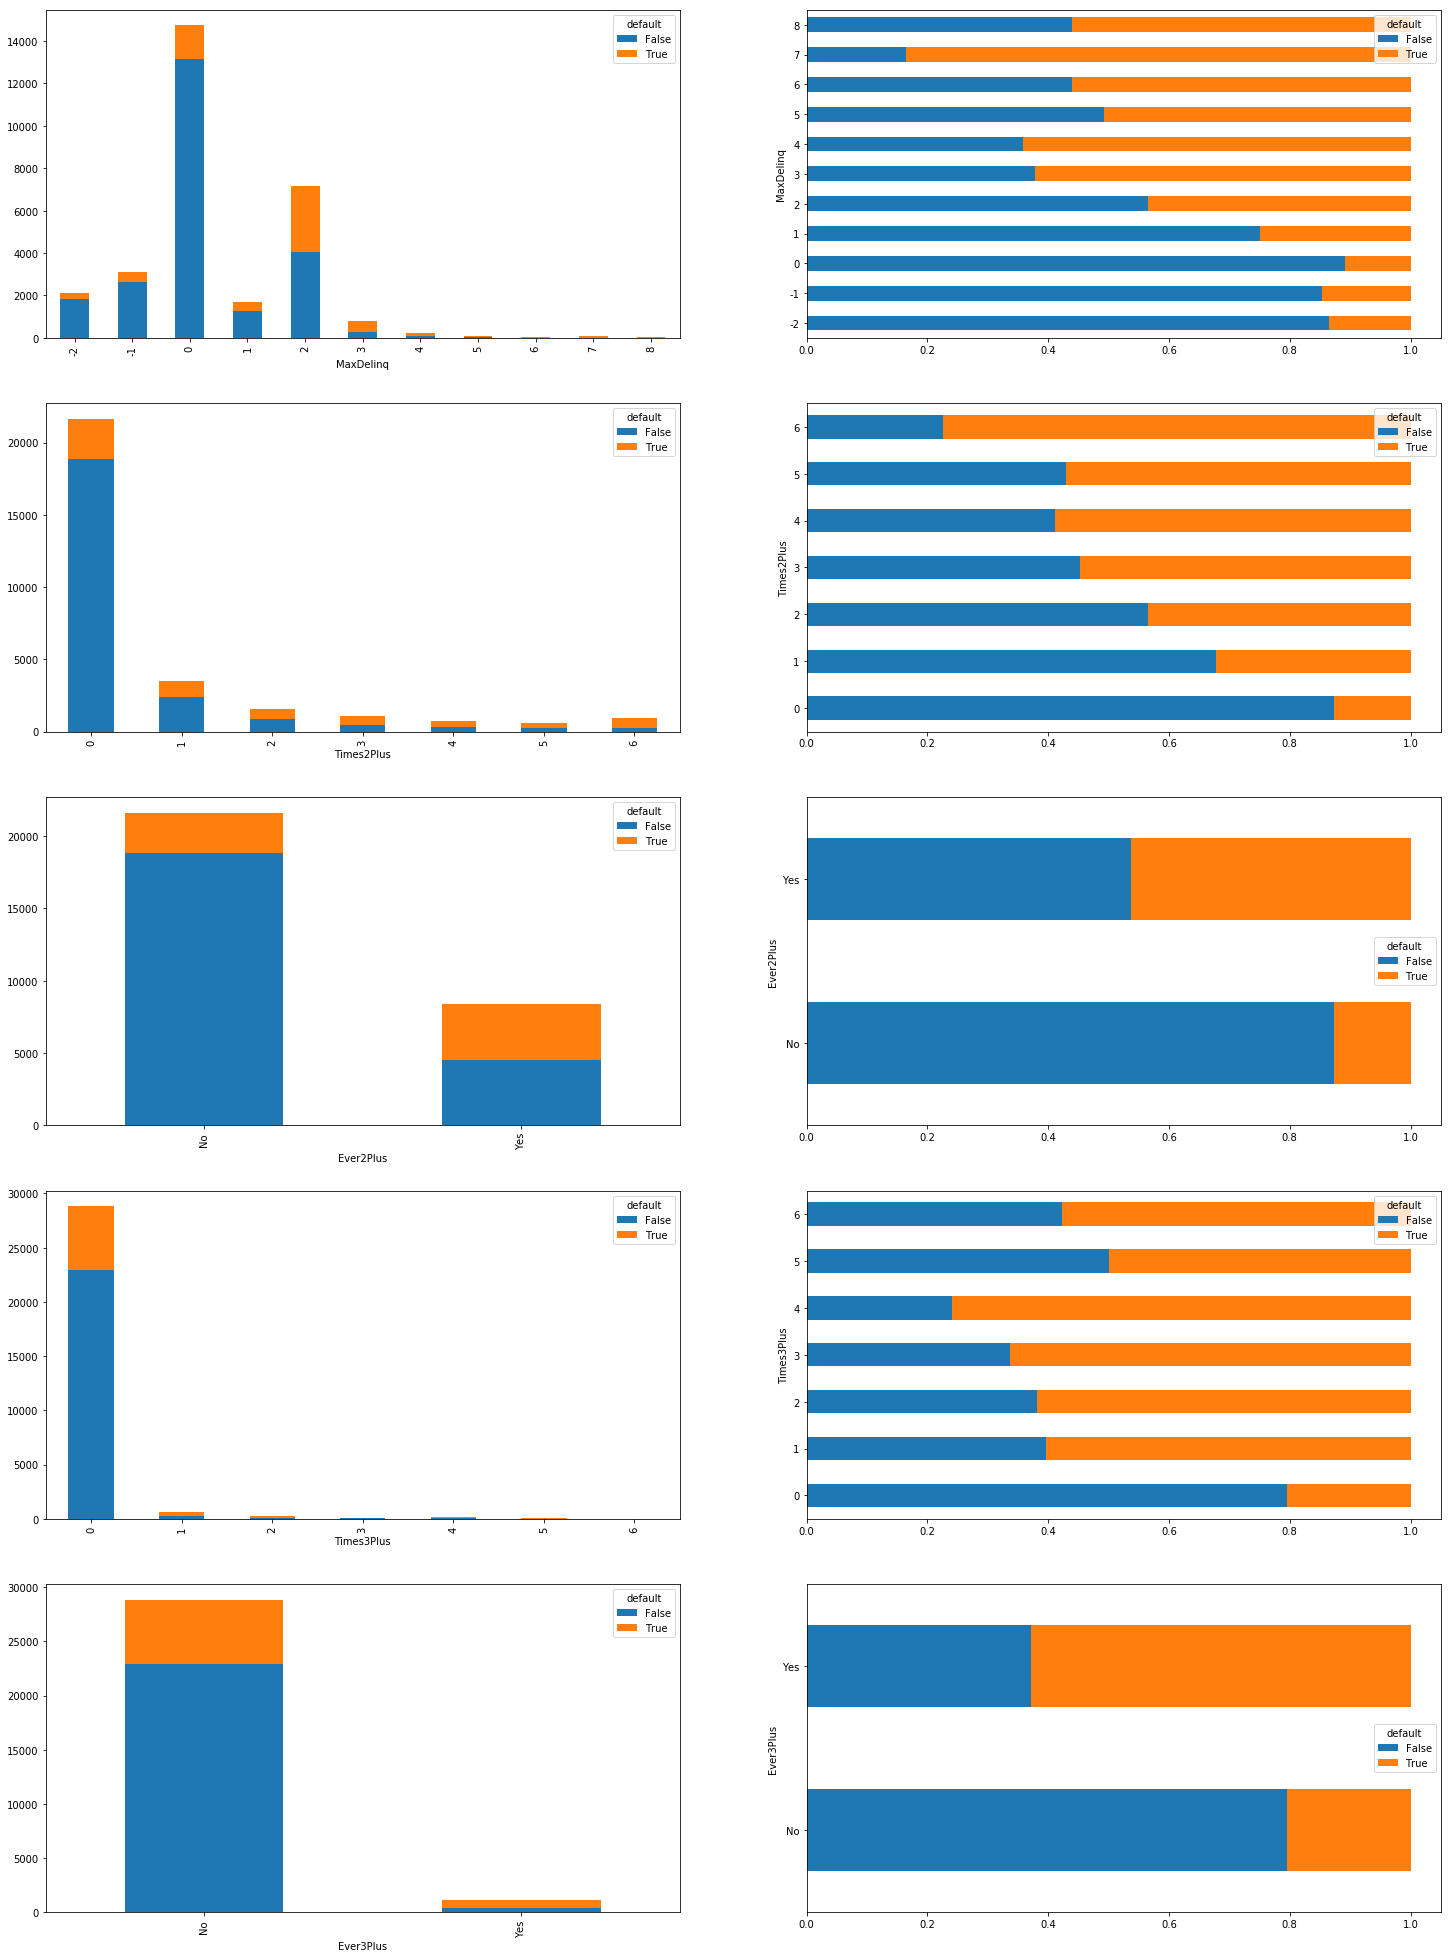

In [8]:
# this python magics will allow plot to be embedded into the notebook
%matplotlib inline
# cross tabs provide a quick view of the relationships between characteristics of the
#borrower & our target FOR THE ONES THAT SEEM TO MAKE THE MOST SENSE
plotVar = ['MaxDelinq','Times2Plus','Ever2Plus','Times3Plus','Ever3Plus']

fig, axes = plt.subplots(nrows=len(plotVar), ncols=2, figsize=(25, 35))

for fi,feature in enumerate(plotVar):
    Counts = pd.crosstab(df[feature],df.default.astype(bool))
    Counts.plot(kind='bar', stacked=True, ax=axes[fi,0])
    
    Rate = Counts.div(Counts.sum(1).astype(float),axis=0)
    Rate.plot(kind='barh', stacked=True, ax=axes[fi,1])
    
plt.show()

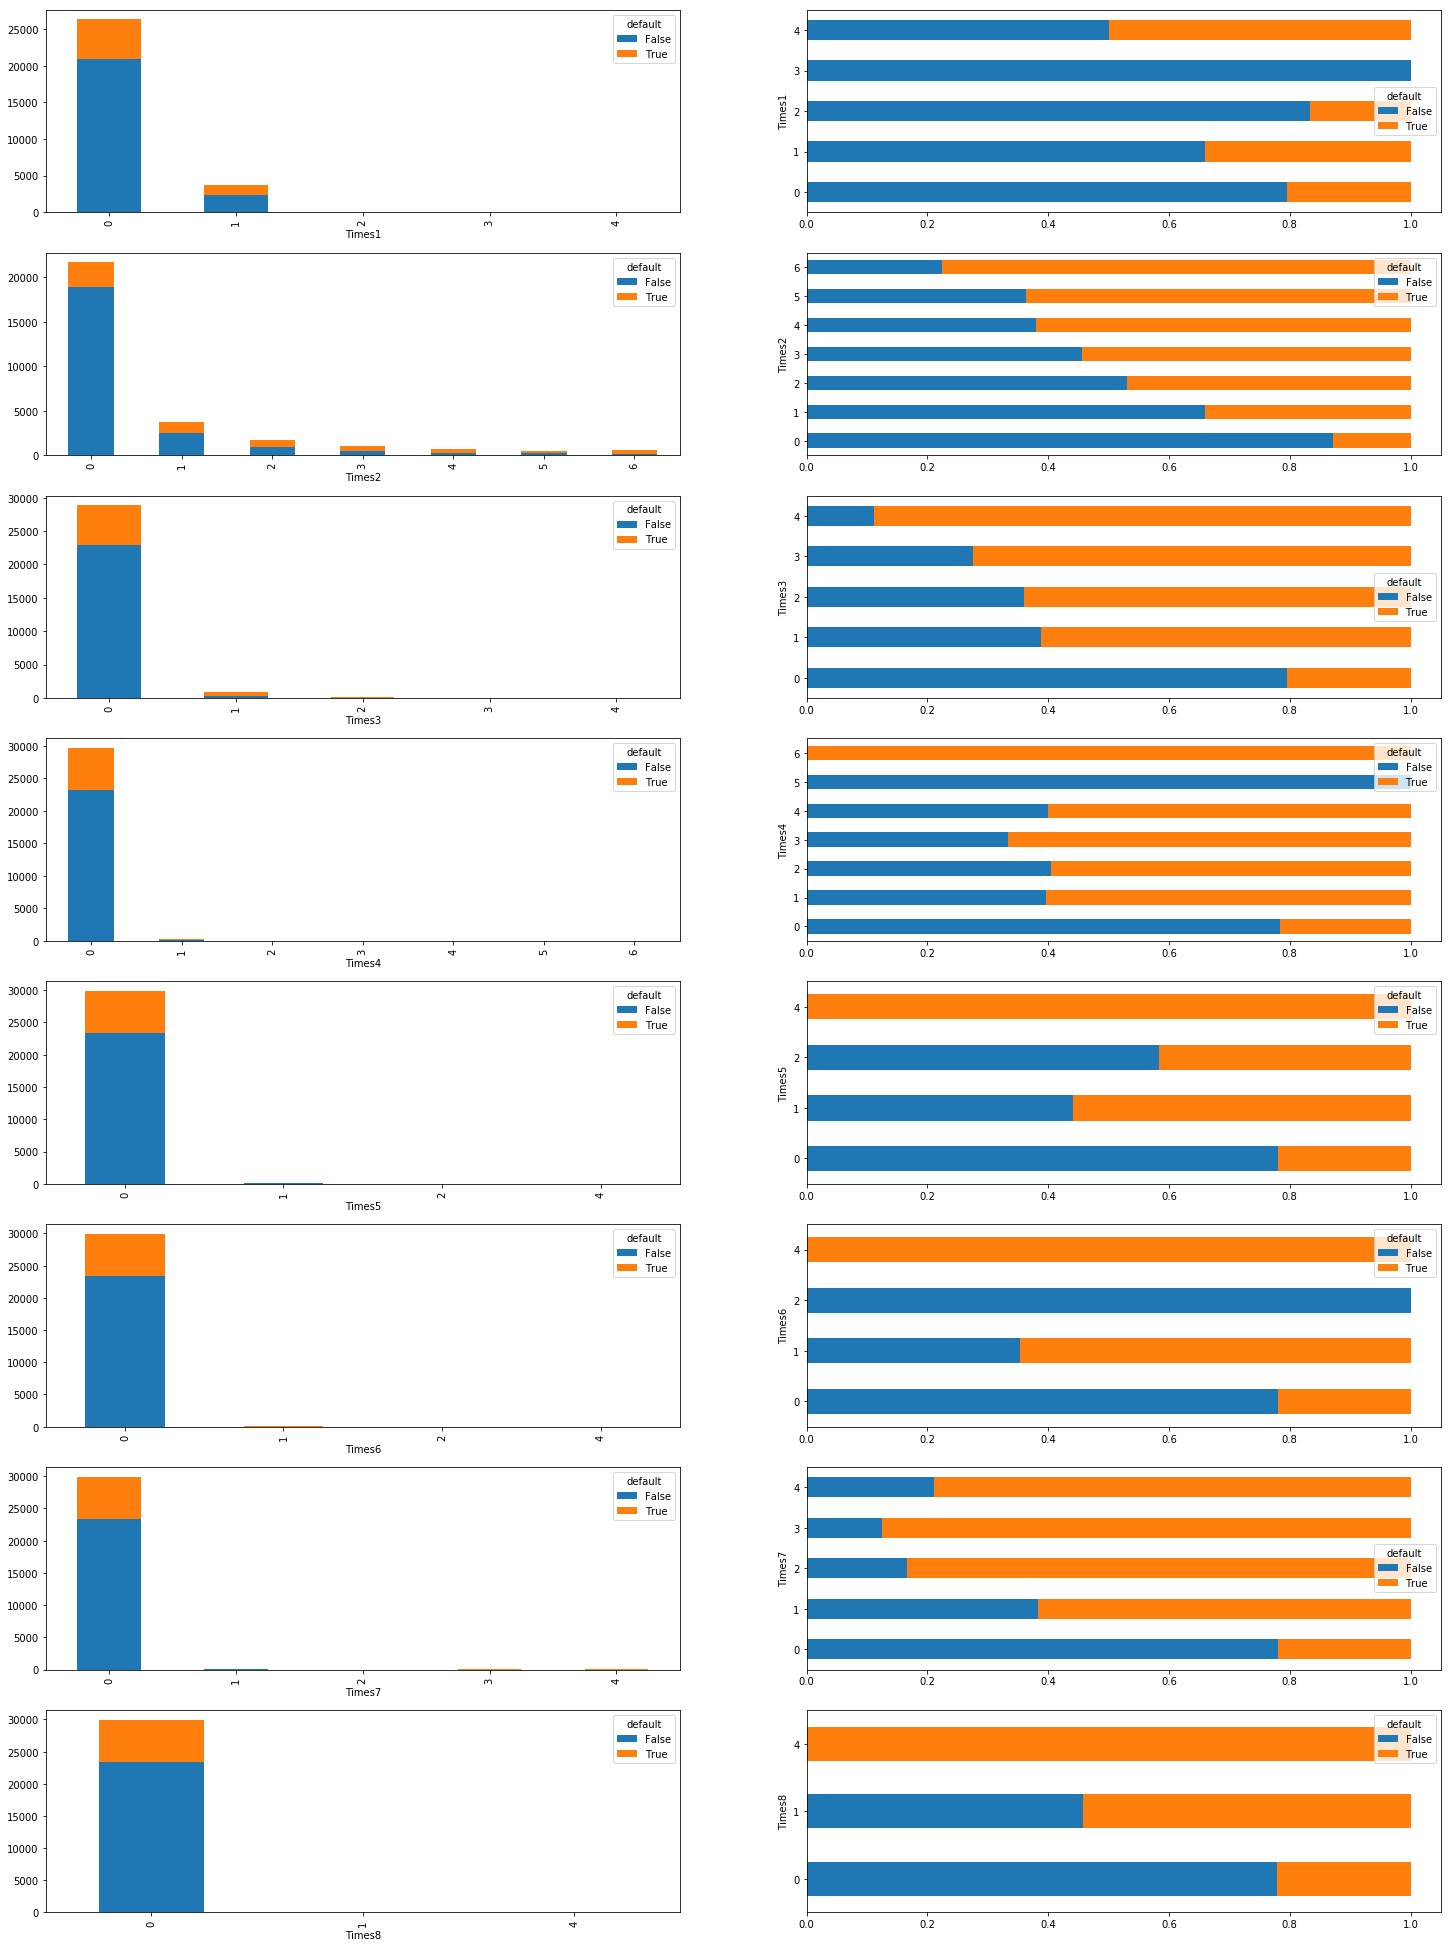

In [9]:
# this python magics will allow plot to be embedded into the notebook
%matplotlib inline
# cross tabs provide a quick view of the relationships between characteristics of the
#borrower & our target FOR SOME OF THE VARIABLES THAT MAY NOT MAKE AS MUCH SENSE AS THE ONES ABOVE.
plotVar = ['Times1','Times2','Times3','Times4','Times5','Times6','Times7','Times8']

fig, axes = plt.subplots(nrows=len(plotVar), ncols=2, figsize=(25, 35))

for fi,feature in enumerate(plotVar):
    Counts = pd.crosstab(df[feature],df.default.astype(bool))
    Counts.plot(kind='bar', stacked=True, ax=axes[fi,0])
    
    Rate = Counts.div(Counts.sum(1).astype(float),axis=0)
    Rate.plot(kind='barh', stacked=True, ax=axes[fi,1])
    
plt.show()

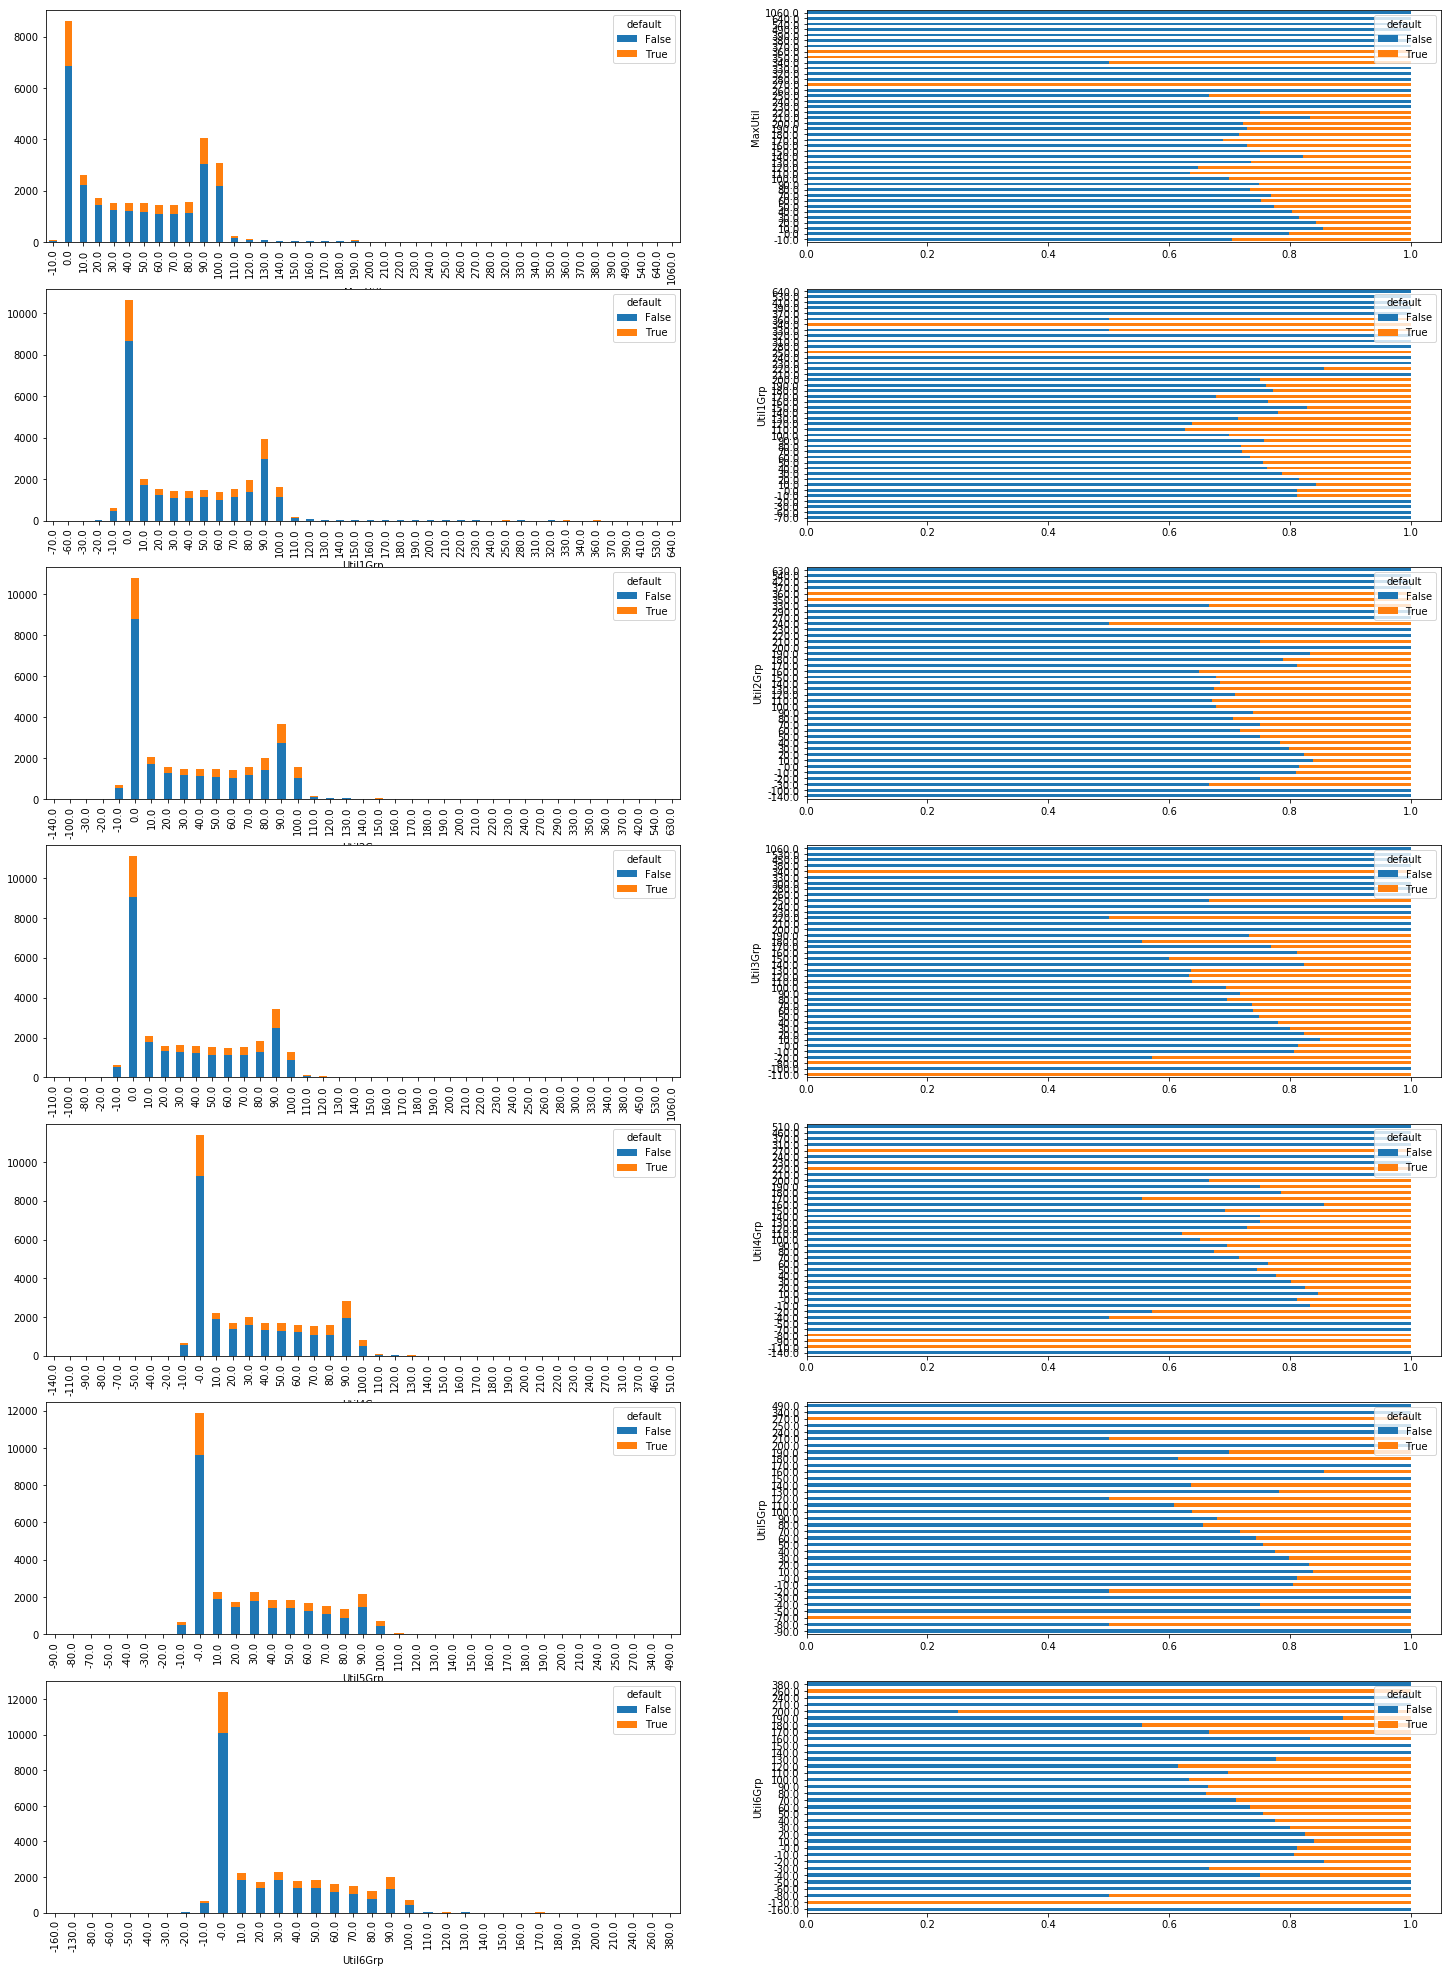

In [14]:
df['Util1']=df['BILL_AMT1']/ df['LIMIT_BAL']
df['Util2']=df['BILL_AMT2']/ df['LIMIT_BAL']
df['Util3']=df['BILL_AMT3']/ df['LIMIT_BAL']
df['Util4']=df['BILL_AMT4']/ df['LIMIT_BAL']
df['Util5']=df['BILL_AMT5']/ df['LIMIT_BAL']
df['Util6']=df['BILL_AMT6']/ df['LIMIT_BAL']

df['Util1Grp']=df['BILL_AMT1']*10// df['LIMIT_BAL']*10
df['Util2Grp']=df['BILL_AMT2']*10// df['LIMIT_BAL']*10
df['Util3Grp']=df['BILL_AMT3']*10// df['LIMIT_BAL']*10
df['Util4Grp']=df['BILL_AMT4']*10// df['LIMIT_BAL']*10
df['Util5Grp']=df['BILL_AMT5']*10// df['LIMIT_BAL']*10
df['Util6Grp']=df['BILL_AMT6']*10// df['LIMIT_BAL']*10

df['MaxUtil'] = df[['Util1Grp','Util2Grp','Util3Grp','Util4Grp','Util5Grp','Util6Grp']].max(axis=1)

%matplotlib inline
# cross tabs provide a quick view of the relationships between characteristics of the
#borrower & our target FOR SOME OF THE VARIABLES THAT MAY NOT MAKE AS MUCH SENSE AS THE ONES ABOVE.
plotVar = ['MaxUtil','Util1Grp','Util2Grp','Util3Grp','Util4Grp','Util5Grp','Util6Grp']

fig, axes = plt.subplots(nrows=len(plotVar), ncols=2, figsize=(25, 35))

for fi,feature in enumerate(plotVar):
    Counts = pd.crosstab(df[feature],df.default.astype(bool))
    Counts.plot(kind='bar', stacked=True, ax=axes[fi,0])
    
    Rate = Counts.div(Counts.sum(1).astype(float),axis=0)
    Rate.plot(kind='barh', stacked=True, ax=axes[fi,1])
    
plt.show()

In [26]:
# Separate the observations into Usage Levels

df['MaxBilledAmount']=df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].max(axis=1) # Variable naming convention is "Delinquent 1 month in Month 0"
df['MaxBilledgroup']=df['MaxBilledAmount']//50000*50000
df.loc[df['MaxBilledAmount']<0,'MaxBilledgroup']='Negative'
df.loc[df['MaxBilledAmount']==0,'MaxBilledgroup']='Zero'
df.loc[df['MaxBilledAmount']>=500000,'MaxBilledgroup']='>=500K'

#testing it
#mxbilled = df.loc[:, ['MaxBilledAmount','MaxBilledgroup']]
#print(mxbilled)
pd.crosstab(df['MaxBilledgroup'],df.default.astype(bool))


default,False,True
MaxBilledgroup,,
0.0,13584,4108
50000.0,4456,1097
100000.0,2048,467
150000.0,1167,265
200000.0,657,131
250000.0,350,80
300000.0,200,54
350000.0,121,34
400000.0,69,14


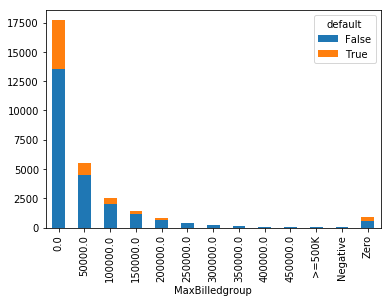

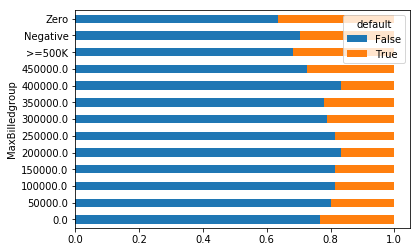

In [32]:
%matplotlib inline
# cross tabs provide a quick view of the relationships between characteristics of the
#borrower & our target FOR SOME OF THE VARIABLES THAT MAY NOT MAKE AS MUCH SENSE AS THE ONES ABOVE.

#fig, axes = plt.subplots(nrows=len(plotVar), ncols=2, figsize=(25, 35))

Counts = pd.crosstab(df['MaxBilledgroup'],df.default.astype(bool))
Counts.plot(kind='bar', stacked=True)#, ax=axes[0,0])
    
Rate = Counts.div(Counts.sum(1).astype(float),axis=0)
Rate.plot(kind='barh', stacked=True)#, ax=axes[0,1])
    
plt.show()


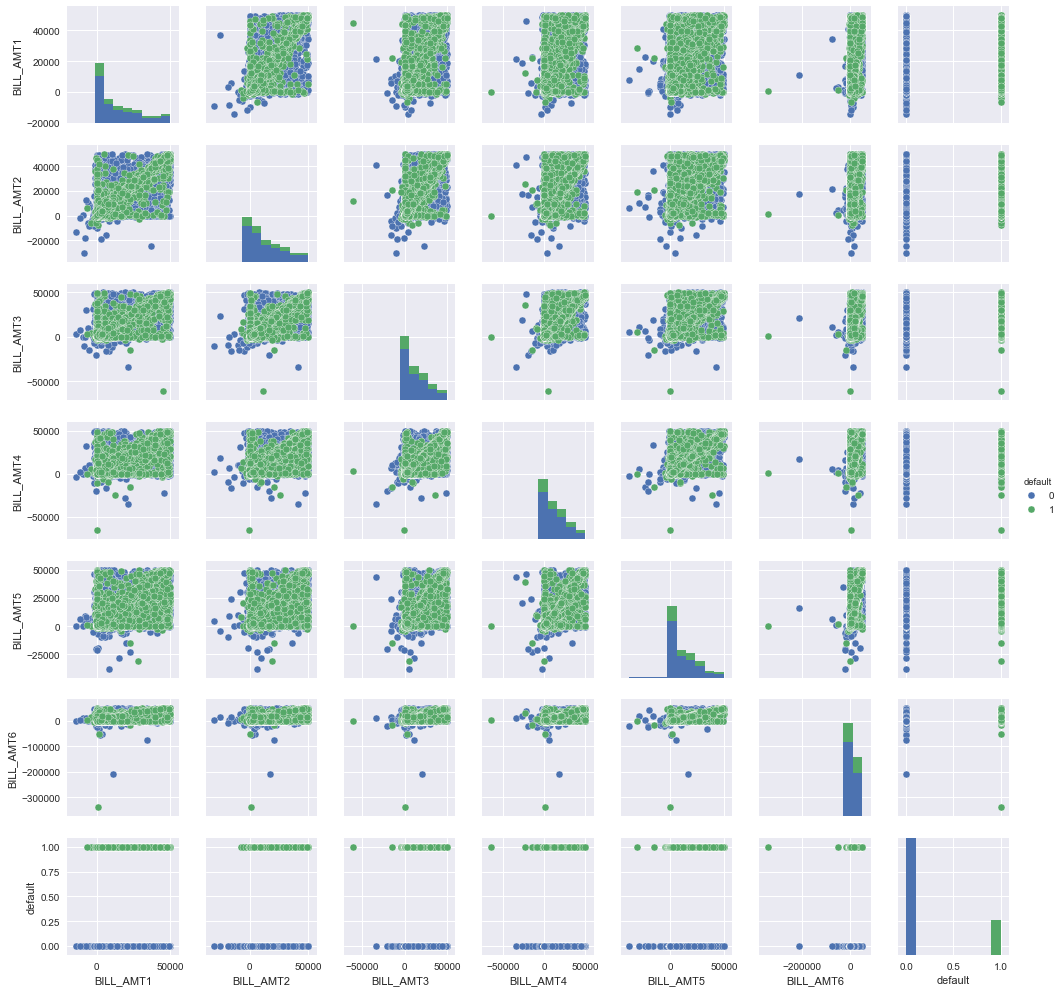

In [42]:
import seaborn as sns
billedgroup0 = df.loc[df['MaxBilledgroup'] == 0]

%matplotlib inline
sns.set()
g=sns.pairplot(billedgroup0[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','default']],hue = 'default',size = 2)

In [3]:
#Create a separate dataset in case we need to come back to original
dfsub = df.copy()
#dfsub = pd.concat((df,tmp_df_1,tmp_df_2),axis=1)

#We will not need these attributes. We are using log of them instead.
del dfsub['LIMIT_BAL']
del dfsub['PAY_AMT1']
del dfsub['PAY_AMT2']
del dfsub['PAY_AMT3']
del dfsub['PAY_AMT4']
del dfsub['PAY_AMT5']
del dfsub['PAY_AMT6']

#We found in Lab1 that there is high correlation between BILL Amount and Pay 
##Amounts so ignore bill amount for now
del dfsub['BILL_AMT1']
del dfsub['BILL_AMT2']
del dfsub['BILL_AMT3']
del dfsub['BILL_AMT4']
del dfsub['BILL_AMT5']
del dfsub['BILL_AMT6']

#Drop variables for which we used one-hot encoding
del dfsub['EDUCATION']
del dfsub['MARRIAGE']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 40 columns):
LIMIT_BAL        30000 non-null float64
SEX              30000 non-null int64
EDUCATION        30000 non-null int64
MARRIAGE         30000 non-null int64
AGE              30000 non-null int64
PAY_0            30000 non-null int64
PAY_2            30000 non-null int64
PAY_3            30000 non-null int64
PAY_4            30000 non-null int64
PAY_5            30000 non-null int64
PAY_6            30000 non-null int64
BILL_AMT1        30000 non-null float64
BILL_AMT2        30000 non-null float64
BILL_AMT3        30000 non-null float64
BILL_AMT4        30000 non-null float64
BILL_AMT5        30000 non-null float64
BILL_AMT6        30000 non-null float64
PAY_AMT1         30000 non-null float64
PAY_AMT2         30000 non-null float64
PAY_AMT3         30000 non-null float64
PAY_AMT4         30000 non-null float64
PAY_AMT5         30000 non-null float64
PAY_AMT6         30000 non-null

In [ ]:
#Create a separate dataset in case we need to come back to original
dfsub = df.copy()
#dfsub = pd.concat((df,tmp_df_1,tmp_df_2),axis=1)

#We will not need these attributes. We are using log of them instead.
del dfsub['LIMIT_BAL']
del dfsub['PAY_AMT1']
del dfsub['PAY_AMT2']
del dfsub['PAY_AMT3']
del dfsub['PAY_AMT4']
del dfsub['PAY_AMT5']
del dfsub['PAY_AMT6']

#We found in Lab1 that there is high correlation between BILL Amount and Pay 
##Amounts so ignore bill amount for now
del dfsub['BILL_AMT1']
del dfsub['BILL_AMT2']
del dfsub['BILL_AMT3']
del dfsub['BILL_AMT4']
del dfsub['BILL_AMT5']
del dfsub['BILL_AMT6']

#Drop variables for which we used one-hot encoding
del dfsub['EDUCATION']
del dfsub['MARRIAGE']

In [ ]:
df[Pay3Plus]=if df